In [2]:
import os
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import openai
from openai import OpenAI

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T


from src.dataset_loaders.download_openimages import OpenImagesLoader
from tqdm import tqdm, tqdm_notebook


In [3]:

# Device Configuration:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Device being used: {device}")

Device being used: cuda


In [3]:
import os
import json
import torchvision.transforms.v2 as transforms
from openimages.download import download_dataset
import random
import shutil
import torch
from torch.utils.data import DataLoader
from PIL import Image as PILImage
from torchvision import tv_tensors
from torchvision.transforms.v2 import Resize
from torchvision.ops import box_convert
from PIL import Image

class DETRDatasetProcessor():

    def __init__(self, random_seed = 101, batch_size = 128, perc_keep = 1.0, num_images_per_class=500):
        self.data_dir = os.path.join("data", "openimages")  # Directory in which dataset resides
        self.random_seed = random_seed
        self.batch_size = batch_size
        self.perc_keep = perc_keep  # Percentage of dataset to be kept (number between 0 and 1)
        self.num_images_per_class = num_images_per_class

        self.transforms_all = transforms.Compose(
            [
                Resize((512, 512)),
            ]
        )

        self.transforms_img = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet's normalization statistics
            ]
        )

        self.classes = [
            "Hot dog", "French fries", "Waffle", "Pancake", "Burrito", "Pretzel",
            "Popcorn", "Cookie", "Muffin", "Ice cream", "Cake", "Candy",
            "Guacamole", "Apple", "Grape", "Common fig", "Pear",
            "Strawberry", "Tomato", "Lemon", "Banana", "Orange", "Peach", "Mango",
            "Pineapple", "Grapefruit", "Pomegranate", "Watermelon", "Cantaloupe",
            "Egg (Food)", "Bagel", "Bread", "Doughnut", "Croissant",
            "Tart", "Mushroom", "Pasta", "Pizza", "Squid",
            "Oyster", "Lobster", "Shrimp", "Crab", "Taco", "Cooking spray",
            "Cucumber", "Radish", "Artichoke", "Potato", "Garden Asparagus",
            "Pumpkin", "Zucchini", "Cabbage", "Carrot", "Salad",
            "Broccoli", "Bell pepper", "Winter melon", "Honeycomb",
            "Hamburger", "Submarine sandwich", "Cheese", "Milk", "Sushi"
        ]


        self.category_mapping = {i: {"id": i + 1, "name": name.lower()} for i, name in enumerate(self.classes)}
        self.class_2_index = {entry["name"]: entry["id"] for entry in self.category_mapping.values()}

        self.train_dir = os.path.join(self.data_dir, "train") # Directory in which train dataset resides
        self.val_dir = os.path.join(self.data_dir, "val") # Directory in which validation dataset resides
        self.test_dir = os.path.join(self.data_dir, "test") # Directory in which test dataset resides

        self.train_red_dir = os.path.join(self.data_dir, "train_red") # Directory in which reduced train dataset resides
        self.val_red_dir = os.path.join(self.data_dir, "val_red") # Directory in which reduced validation dataset resides
        self.test_red_dir = os.path.join(self.data_dir, "test_red") # Directory in which reduced test dataset resides


    def download_data(self, annotation_format='darknet'):
        # download_dataset(self.data_dir, self.classes, annotation_format=annotation_format, limit=5)
        
        for class_name in self.classes:
            print(f'Attempting to download {class_name} data')
            
            if not os.path.isdir(os.path.join(self.data_dir, class_name.lower())):
                try:
                    download_dataset(self.data_dir, [class_name], annotation_format=annotation_format, limit=500)
                except Exception as e:
                    print(f'An exception occurred for {class_name}. ERROR: {e}')
            else:
                print(f'Skipped {class_name}, data already downloaded')


    def split_data(self, keep_class_dirs=True):

        """ This function splits the downloaded Open Image dataset, and splits each class into training, validation, and testing sets.
            This function assumes that the required data has already been downloaded."""

        # Setting the random seed:
        random.seed(self.random_seed)
        
        splits = ["train", "val", "test"]

        # Making folders for each of the splits:
        for split in splits:
            split_dir = os.path.join(self.data_dir, split)
            os.makedirs(split_dir, exist_ok=True)

        # Iterating through each class:
        for class_cur in self.classes:
            print(f'Splitting data for class {class_cur}')

            # Getting directories for the images and annotations for each class:
            imgs_dir = os.path.join(self.data_dir, class_cur.lower(), "images")
            anns_dir = os.path.join(self.data_dir, class_cur.lower(), "darknet")

            # Ensuring each class has images and annotations:
            if not imgs_dir:
                raise Exception(f'Images do not exist for {class_cur}!')

            if not anns_dir:
                raise Exception(f'Annotations do not exist for {class_cur}!')

            class_imgs = os.listdir(imgs_dir) # Images for current class
            class_anns = os.listdir(anns_dir) # Annotations for current class
            class_imgs.sort()
            class_anns.sort()

            num_imgs = len(class_imgs) # Number of images and annotations for current class
            
            # Shuffling data:
            inds_list = list(range(num_imgs)) # List of indices ranging for the total number of images
            random.shuffle(inds_list) # Shuffling indices list
            class_imgs = [class_imgs[i] for i in inds_list] # Shuffling class images according to shuffled inds_list
            class_anns = [class_anns[i] for i in inds_list] # Shuffling class annotations according to shuffled inds_list

            ind_train = int(0.8 * num_imgs) # Ending index for the training images
            ind_val = ind_train + int(0.1 * num_imgs) # Ending index for the validation images

            # Splitting images into training, validation, and testing:
            train_imgs = class_imgs[:ind_train]
            val_imgs = class_imgs[ind_train:ind_val]
            test_imgs = class_imgs[ind_val:]

            all_imgs = [train_imgs, val_imgs, test_imgs] # All images
            
            # Splitting annotations into training, validation, and testing:
            train_anns = class_anns[:ind_train]
            val_anns = class_anns[ind_train:ind_val]
            test_anns = class_anns[ind_val:]

            all_anns = [train_anns, val_anns, test_anns] # All annotations
            
            # Looping through all split types and corresponding split images:
            for split_type, split_imgs, split_anns in zip(splits, all_imgs, all_anns):
                if keep_class_dirs:
                    # Creating each split directory for images and annotations for current class:
                    split_dir_img = os.path.join(self.data_dir, split_type, class_cur.lower(), "images")
                    split_dir_ann = os.path.join(self.data_dir, split_type, class_cur.lower(), "annotations")
                else:
                    split_dir_img = os.path.join(self.data_dir, split_type, "images")
                    split_dir_ann = os.path.join(self.data_dir, split_type, "annotations")

                os.makedirs(split_dir_img, exist_ok=True)
                os.makedirs(split_dir_ann, exist_ok=True)

                # Copying each image from initial directory to corresponding split directory for each split:
                for img, ann in zip(split_imgs, split_anns):
                    shutil.copy(os.path.join(imgs_dir, img), os.path.join(split_dir_img, img))
                    shutil.copy(os.path.join(anns_dir, ann), os.path.join(split_dir_ann, ann))

                    # Code to replace each original class label (which is 0) to the class label as found in self.class_2_index:
                    ann_file_cur_dir = os.path.join(split_dir_ann, ann) # File path of current annotation file
                    with open(ann_file_cur_dir, 'r') as file:
                        objects = file.readlines()

                        new_labels = []
                        for obj in objects:
                            obj_items = obj.split()
                            new_class_label = self.class_2_index[class_cur.lower()]
                            obj_items[0] = str(new_class_label)

                            obj_new = ' '.join(obj_items) + '\n'
                            new_labels.append(obj_new)
                    
                    with open(ann_file_cur_dir, 'w') as file:
                        file.writelines(new_labels)
                            

    def split_data_reduced(self, keep_class_dirs=True):

        """ This function splits the downloaded Open Image dataset, and splits each class into training, validation, and testing sets.
            This function assumes that the required data has already been downloaded.
            This function reduces the dataset by self.keep_perc. """

        # Setting the random seed:
        random.seed(self.random_seed)
        
        splits = ["train_red", "val_red", "test_red"]
        
        # Making folders for each of the splits:
        for split in splits:
            split_dir = os.path.join(self.data_dir, split)
            os.makedirs(split_dir, exist_ok=True)

        # Iterating through each class:
        for class_cur in self.classes:
            print(f'Splitting data for class {class_cur}')

            # Getting directories for the images and annotations for each class:
            imgs_dir = os.path.join(self.data_dir, class_cur.lower(), "images")
            anns_dir = os.path.join(self.data_dir, class_cur.lower(), "darknet")

            # Ensuring each class has images and annotations:
            if not imgs_dir:
                raise Exception(f'Images do not exist for {class_cur}!')

            if not anns_dir:
                raise Exception(f'Annotations do not exist for {class_cur}!')

            class_imgs = os.listdir(imgs_dir) # Images for current class
            class_anns = os.listdir(anns_dir) # Annotations for current class
            class_imgs.sort()
            class_anns.sort()

            num_imgs = len(class_imgs) # Number of images and annotations for current class
            
            if self.perc_keep != 1.00 and num_imgs > 50:
                num_imgs = int(num_imgs * self.perc_keep)
                class_imgs = class_imgs[:num_imgs]
                class_anns = class_anns[:num_imgs]

            # Shuffling data:
            inds_list = list(range(num_imgs)) # List of indices ranging for the total number of images
            random.shuffle(inds_list) # Shuffling indices list
            class_imgs = [class_imgs[i] for i in inds_list] # Shuffling class images according to shuffled inds_list
            class_anns = [class_anns[i] for i in inds_list] # Shuffling class annotations according to shuffled inds_list

            ind_train = int(0.8 * num_imgs) # Ending index for the training images
            ind_val = ind_train + int(0.1 * num_imgs) # Ending index for the validation images

            # Splitting images into training, validation, and testing:
            train_imgs = class_imgs[:ind_train]
            val_imgs = class_imgs[ind_train:ind_val]
            test_imgs = class_imgs[ind_val:]

            all_imgs = [train_imgs, val_imgs, test_imgs] # All images
            
            # Splitting annotations into training, validation, and testing:
            train_anns = class_anns[:ind_train]
            val_anns = class_anns[ind_train:ind_val]
            test_anns = class_anns[ind_val:]

            all_anns = [train_anns, val_anns, test_anns] # All annotations
            
            # Looping through all split types and corresponding split images:
            for split_type, split_imgs, split_anns in zip(splits, all_imgs, all_anns):
                if keep_class_dirs:
                    # Creating each split directory for images and annotations for current class:
                    split_dir_img = os.path.join(self.data_dir, split_type, class_cur.lower(), "images")
                    split_dir_ann = os.path.join(self.data_dir, split_type, class_cur.lower(), "annotations")
                else:
                    split_dir_img = os.path.join(self.data_dir, split_type, "images")
                    split_dir_ann = os.path.join(self.data_dir, split_type, "annotations")

                os.makedirs(split_dir_img, exist_ok=True)
                os.makedirs(split_dir_ann, exist_ok=True)

                # Copying each image from initial directory to corresponding split directory for each split:
                for img, ann in zip(split_imgs, split_anns):
                    shutil.copy(os.path.join(imgs_dir, img), os.path.join(split_dir_img, img))
                    shutil.copy(os.path.join(anns_dir, ann), os.path.join(split_dir_ann, ann))

                    # Code to replace each original class label (which is 0) to the class label as found in self.class_2_index:
                    ann_file_cur_dir = os.path.join(split_dir_ann, ann) # File path of current annotation file
                    with open(ann_file_cur_dir, 'r') as file:
                        objects = file.readlines()

                        new_labels = []
                        for obj in objects:
                            obj_items = obj.split()
                            new_class_label = self.class_2_index[class_cur.lower()]
                            obj_items[0] = str(new_class_label)

                            obj_new = ' '.join(obj_items) + '\n'
                            new_labels.append(obj_new)
                    
                    with open(ann_file_cur_dir, 'w') as file:
                        file.writelines(new_labels)

        print(f"Dataset has been reduced!")



    def convert_to_coco(self, reduced=True):
        """ This function strives to convert the darknet annotations into COCO format. """

        # Split names:
        if reduced:
            splits = ["train_red", "val_red", "test_red"]
        else:
            splits = ["train", "val", "test"]

        # Getting categories with category labels and corresponding id's:
        categories = list(self.category_mapping.values())

        # Initializing annotation and image id's:        
        annotation_id = 1
        image_id = 1
        
        # Iterating through all of the splits
        for i, split in enumerate(splits):

            coco_format = {
                "images": [],
                "annotations": [],
                "categories": categories
            }

            img_folder = os.path.join(self.data_dir, split, "images")
            ann_folder = os.path.join(self.data_dir, split, "annotations")

            for img_file in os.listdir(img_folder):
                
                img_file_path = os.path.join(img_folder, img_file)
                img = Image.open(img_file_path)
                width, height = img.size
                coco_format["images"].append({
                    "id": image_id,
                    "file_name": img_file,
                    "width": width,
                    "height": height
                })

                # Annotation:
                ann_file_path = os.path.join(ann_folder, img_file.replace(".jpg", ".txt"))                
                with open(ann_file_path, "r") as f:
                    lines = f.readlines()
                    for line in lines:
                        parts = line.strip().split()
                        class_id = int(parts[0])
                        x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])
                        
                        # Convert to COCO bbox format [x_min, y_min, width, height]:
                        x_min = (x_center - bbox_width / 2) * width
                        y_min = (y_center - bbox_height / 2) * height
                        bbox_width *= width
                        bbox_height *= height
                        
                        # Annotation information:
                        coco_format["annotations"].append({
                            "id": annotation_id,
                            "image_id": image_id,
                            "category_id": class_id,
                            "bbox": [x_min, y_min, bbox_width, bbox_height],
                            "area": bbox_width * bbox_height,
                            "iscrowd": 0
                        })

                        # Incrementing the annotation id:
                        annotation_id += 1
                
                # Incrementing the image id:
                image_id += 1

            # Setting the name of the .json file accordingly:
            if i == 0:
                with open("instances_train2017.json", "w") as f:
                    json.dump(coco_format, f, indent=4)                    
            elif i == 1:
                with open("instances_val2017.json", "w") as f:
                    json.dump(coco_format, f, indent=4)                    
            else:
                with open("test_coco.json", "w") as f:
                    json.dump(coco_format, f, indent=4)                    
            
            print(f"Converted {split} to coco format!")




In [4]:
# Data Configuration & Hyperparameters:
PERC_KEEP = 0.50 # Proportion of data from datasets to keep
BATCH_SIZE = 16 # Batch size
EPOCHS = 50 # Number of epochs to train the model for
LEARNING_RATE = 1e-4 # Learning rate

In [5]:
### Loading Open Images Dataset:

# Initializing the DETRDatasetProcessor class:
detr_processor = DETRDatasetProcessor(batch_size=BATCH_SIZE, perc_keep=PERC_KEEP)
print(f"Number of classes: {len(detr_processor.classes)}")

# Downloading the Open Images Dataset in darknet format:
# detr_processor.download_data()

# Splitting the downloaded data into training, validation, and test sets:
# detr_processor.split_data(keep_class_dirs=False)

# Splitting the downloaded data into reduced training, validation, and test sets:
# detr_processor.split_data_reduced(keep_class_dirs=False)

# detr_processor.convert_to_coco(reduced=False)




Number of classes: 64


In [ ]:
print(detr_processor.category_mapping[63])

In [ ]:
### Applying image augmentations to a randomly sampled batch of images from the training set:

# from PIL import Image
# from torchvision import transforms
# import random

# # Setting random seed:
# random.seed(42)

# # Path of the training images to be augmented:
# train_dir = os.path.join("data", "detr_full_augment", "train2017")

# augment_perc = 0.4 # Percentage of images desired to be augmented
# num_imgs_to_augment = int(augment_perc * len(os.listdir(train_dir))) # Getting number of images to be augmented

# img_augmentation = transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)]) # Augmentation

# all_imgs = os.listdir(train_dir)
# imgs_sel = random.sample(all_imgs, num_imgs_to_augment) # Randomly sampling a percentage of the images to be augmented

# # Augmenting each selected image:
# for img in imgs_sel:
#     img_file_path = os.path.join(train_dir, img)

#     img_pil = Image.open(img_file_path)

#     img_augment = img_augmentation(img_pil)

#     img_augment.save(img_file_path)

# print("Applied image augmentations.")


In [ ]:
# Can also run this command in the terminal:
%run detr/main.py --coco_path ".\data\detr" --output_dir "." --epochs 150

In [ ]:
# Loading pre-trained DETR R50 model:
checkpoint_path = "detr-r50-e632da11.pth"  # Path to the original checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# Removing the class_embed weights from the checkpoint:
checkpoint["model"] = {k: v for k, v in checkpoint["model"].items() if not k.startswith("class_embed")}

# Loading the pretrained DETR model from PyTorch Hub to have a base model object to work off of:
detr_model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

# Replacing the classification head to match the number of custom classes:
num_labels = 66
detr_model.class_embed = nn.Linear(detr_model.class_embed.in_features, num_labels)

# Initializing new classification head:
nn.init.xavier_uniform_(detr_model.class_embed.weight)
nn.init.constant_(detr_model.class_embed.bias, 0)

# Loading the modified checkpoint into the model:
detr_model.load_state_dict(checkpoint["model"], strict=False)

# Saving the modified model's state dictionary:
model_path = "modified_detr.pth"
torch.save({'model': detr_model.state_dict()}, model_path)

print(f"Modified model saved to {model_path}")


In [ ]:
# Checking training results:

# from detr.util.plot_utils import plot_logs

import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path, PurePath


""" This function is a modification of the detr.util.plot_utils.plot_logs function from FacebookResearch's DETR repository. """
def plot_logs(logs, fields=('class_error', 'loss_bbox_unscaled', 'mAP'), ewm_col=0, log_name='log.txt'):
    # (Previous input validation code remains the same)

    # load log file(s) and plot
    dfs = [pd.read_json(Path(p) / log_name, lines=True) for p in logs]

    fig, axs = plt.subplots(ncols=len(fields), figsize=(16, 5))
    
    for df, color in zip(dfs, sns.color_palette(n_colors=len(logs))):
        for j, field in enumerate(fields):
            try:
                if field == 'mAP':
                    if 'test_coco_eval_bbox' in df.columns:
                        coco_eval = df['test_coco_eval_bbox'].dropna().apply(
                            lambda x: np.mean(x) if isinstance(x, list) else x
                        )
                        coco_eval = pd.Series(coco_eval).ewm(com=ewm_col).mean()
                        axs[j].plot(coco_eval, c=color)
                else:
                    train_col = f'train_{field}'
                    test_col = f'test_{field}'
                    
                    if train_col in df.columns and test_col in df.columns:
                        train_data = pd.to_numeric(df[train_col], errors='coerce')
                        test_data = pd.to_numeric(df[test_col], errors='coerce')
                        
                        train_smooth = train_data.interpolate().ewm(com=ewm_col).mean()
                        test_smooth = test_data.interpolate().ewm(com=ewm_col).mean()
                        
                        axs[j].plot(train_smooth, c=color, linestyle='-')
                        axs[j].plot(test_smooth, c=color, linestyle='--')
            
            except Exception as e:
                print(f"Error plotting {field}: {e}")
                continue

    # Add legends and titles
    for ax, field in zip(axs, fields):
        ax.legend([Path(p).name for p in logs])
        ax.set_title(field)
        ax.set_xlabel('Epochs')    

    plt.tight_layout()
    plt.show()


log_directory = [Path('outputs_50_full_augment/')]
fields_of_interest = ('loss', 'mAP', 'class_error', 'loss_bbox')

plot_logs(log_directory, fields_of_interest)



In [6]:
### Checking results:

# Loading the pretrained DETR model from PyTorch Hub to have a base model object to work off of:
detr_model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

# # Replacing the classification head to match the number of custom classes:
num_labels = 66
detr_model.class_embed = nn.Linear(detr_model.class_embed.in_features, num_labels)

# Loading custom-trained DETR R50 model:
# checkpoint_path = "detr-r50-e632da11.pth"
checkpoint_path = os.path.join("outputs_50_100_full", "checkpoint.pth")
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# Loading custom trained checkpoint into the model:
detr_model.load_state_dict(checkpoint["model"], strict=False)
detr_model.eval()


Using cache found in C:\Users\Praveen Ravishankar/.cache\torch\hub\facebookresearch_detr_main


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

2024-12-11  10:10:33 INFO HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


['Bell pepper']
LLM Response: Bell pepper is a popular vegetable known for its vibrant colors and crunchy texture. Here is the nutritional information and notable health benefits of bell pepper:

Nutritional information (per 100g serving of raw bell pepper):
- Calories: 31 kcal
- Carbohydrates: 6g
- Fiber: 2.1g
- Protein: 1g
- Fat: 0.3g
- Vitamin C: 127.7mg (213% DV)
- Vitamin A: 3131 IU (63% DV)
- Vitamin K: 7.4 mcg (9% DV)
- Potassium: 211mg

Notable health benefits:
1. Rich in vitamin C: Bell peppers are an excellent source of vitamin C, which acts as an antioxidant in the body, helping to protect cells from damage and boosting the immune system.
2. High in antioxidants: Bell peppers are rich in various antioxidants, including carotenoids and flavonoids, which have been linked to a reduced risk of chronic diseases such as heart disease and certain types of cancer.
3. Low in calories: Bell peppers are a low-calorie food, making them a great option for those looking to manage their we

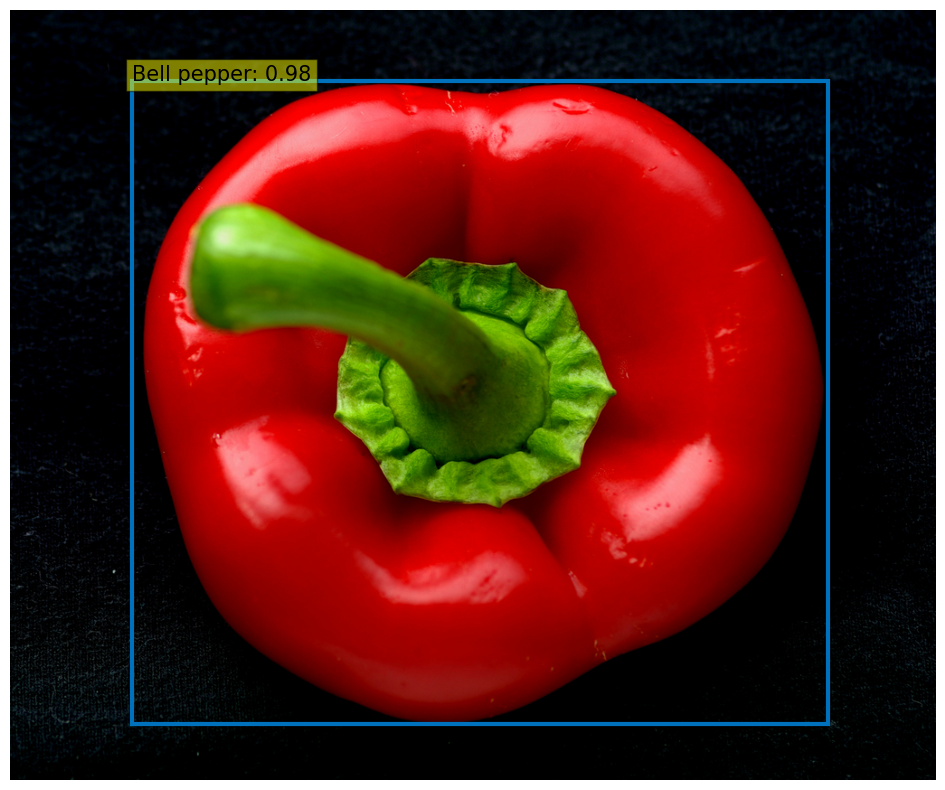

In [ ]:

# classes = detr_processor.classes

classes = [
    "N/A", "Hot dog", "French fries", "Waffle", "Pancake", "Burrito", "Pretzel",
    "Popcorn", "Cookie", "Muffin", "Ice cream", "Cake", "Candy",
    "Guacamole", "Apple", "Grape", "Common fig", "Pear",
    "Strawberry", "Tomato", "Lemon", "Banana", "Orange", "Peach", "Mango",
    "Pineapple", "Grapefruit", "Pomegranate", "Watermelon", "Cantaloupe",
    "Egg (Food)", "Bagel", "Bread", "Doughnut", "Croissant",
    "Tart", "Mushroom", "Pasta", "Pizza", "Squid",
    "Oyster", "Lobster", "Shrimp", "Crab", "Taco", "Cooking spray",
    "Cucumber", "Radish", "Artichoke", "Potato", "Garden Asparagus",
    "Pumpkin", "Zucchini", "Cabbage", "Carrot", "Salad",
    "Broccoli", "Bell pepper", "Winter melon", "Honeycomb",
    "Hamburger", "Submarine sandwich", "Cheese", "Milk", "Sushi"
]


# Following plotting code was retrieved from Facebook Research's public Hands-On DETR Tutorial Google Colab notebook:
# https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{classes[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


# From OpenAI's API documentation:
def prompt_llm(client, prompt):
    """Prompts GPT-3.5 for a response."""

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0.7
        )
        return response.choices[0].message.content
    except openai.OpenAIError as e:
        print(f"An error occurred: {e}")
        return "Error in generating response."



openai.api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

transforms = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_imgs_dir = os.path.join("data", "openimages", "test", "images") # Directory for test images
num_test_imgs = len(os.listdir(test_imgs_dir)) # Total number of test images
num_test_imgs_des = 1 # Desired number of test images
test_imgs_names = random.sample(os.listdir(test_imgs_dir), num_test_imgs_des)
# test_imgs_names = [os.listdir(test_imgs_dir)[545]]
# test_imgs_names = ["c770bae3baf11c07.jpg", "17ba4ea1846b5d0c.jpg", "02924ae5412e1165.jpg"]

confidence_thresh = 0.05 # Confidence threshold for bounding boxes
for img_name in test_imgs_names:
    img_dir = os.path.join(test_imgs_dir, img_name) # Image directory
    img = Image.open(img_dir) # Test image

    img_trans = transforms(img).unsqueeze(0) # Applying transforms to image and extracting batch_size dimension

    # Passing image as input to model:
    output = detr_model(img_trans)

    # Extracting labels that pass the confidence threshold:
    probs = output['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probs.max(-1).values > confidence_thresh
    bboxes_scaled = rescale_bboxes(output['pred_boxes'][0, keep], img.size)

    # Extracting all unique food labels in the image:
    food_labels = list(set([classes[p.argmax()] for p in probs[keep]]))

    # Creating prompt and prompting LLM:
    prompt = "You are a health nutritionist or dietician and an expert in this field. You are provided with various foods: " + \
             str(food_labels) + ". Please provide me with the nutritional information and notable health information of each of these foods."
    response = prompt_llm(client, prompt)

    print(food_labels)
    print(f"LLM Response: {response}")
    print(img_name)
    plot_results(img, probs[keep], bboxes_scaled)